In [1]:
import os
import time
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.transforms import transforms
from scipy.ndimage import gaussian_filter
from scipy.spatial.distance import cdist
from scipy.io import loadmat

In [2]:
torch.manual_seed(42)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Model

In [4]:
vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

class CSRNet(nn.Module):

    def __init__(self):

        super().__init__()
        self.frontend = nn.Sequential(*list(vgg16.features.children())[0:23])

        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=1)
        )
    

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        return x

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 207MB/s] 


In [ ]:
model = CSRNet()
model = model.to(device)

# Dataset Pipeline

In [5]:
k_nearest = 3
beta = 0.3

def generate_density_map(img, points):

    img_width, img_height = img.size
    d_map_height = img_height // 8
    d_map_width = img_width // 8
    density_map = np.zeros((d_map_height, d_map_width), dtype=np.float32)
    
    if len(points) == 0:
        return density_map

    scaled_points = points / 8
    
    sigmas = []
    if len(scaled_points) > 1:
        distances = cdist(scaled_points, scaled_points)
        
        for i in range(len(scaled_points)):
            sorted_distances = np.sort(distances[i][distances[i] > 1e-6])
            
            if len(sorted_distances) >= k_nearest:
                d_k = sorted_distances[k_nearest - 1]
                sigma_i = beta * d_k
            else:
                sigma_i = beta * np.mean(sorted_distances) if len(sorted_distances) > 0 else 1.0
            sigmas.append(sigma_i)
    else:
        sigmas.append(4.0)
    
    sigmas = np.array(sigmas)
    
    for i, (x, y) in enumerate(scaled_points):
        if int(y) < d_map_height and int(x) < d_map_width:
            point_map = np.zeros_like(density_map)
            point_map[int(y), int(x)] = 1.0
            
            blurred_point_map = gaussian_filter(point_map, sigma=sigmas[i], mode='constant')

            density_map += blurred_point_map
    
    return density_map

In [6]:
class CustomDataset(Dataset):

    def __init__(self, img_folder_path, point_folder_path):
        self.img_folder_path = img_folder_path
        self.point_folder_path = point_folder_path
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])


    def __len__(self):
        return(len(os.listdir(self.img_folder_path)))


    def __getitem__(self, index):
        img_path = os.path.join(self.img_folder_path, f"IMG_{index+1}.jpg")
        point_path = os.path.join(self.point_folder_path, f"GT_IMG_{index+1}.mat")

        img = Image.open(img_path).convert("RGB")

        data = loadmat(point_path)
        point = data["image_info"][0][0][0][0][0]

        density_map = generate_density_map(img, points=point.astype(int))
        density_map = torch.from_numpy(density_map).float().unsqueeze(0)

        img = self.transform(img)

        return img, density_map

In [7]:
train_dataset = CustomDataset("/kaggle/input/crowd-dataset/crowd_wala_dataset/train_data/images", "/kaggle/input/crowd-dataset/crowd_wala_dataset/train_data/ground_truth")
test_dataset = CustomDataset("/kaggle/input/crowd-dataset/crowd_wala_dataset/test_data/images", "/kaggle/input/crowd-dataset/crowd_wala_dataset/test_data/ground_truth")

In [8]:
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4)

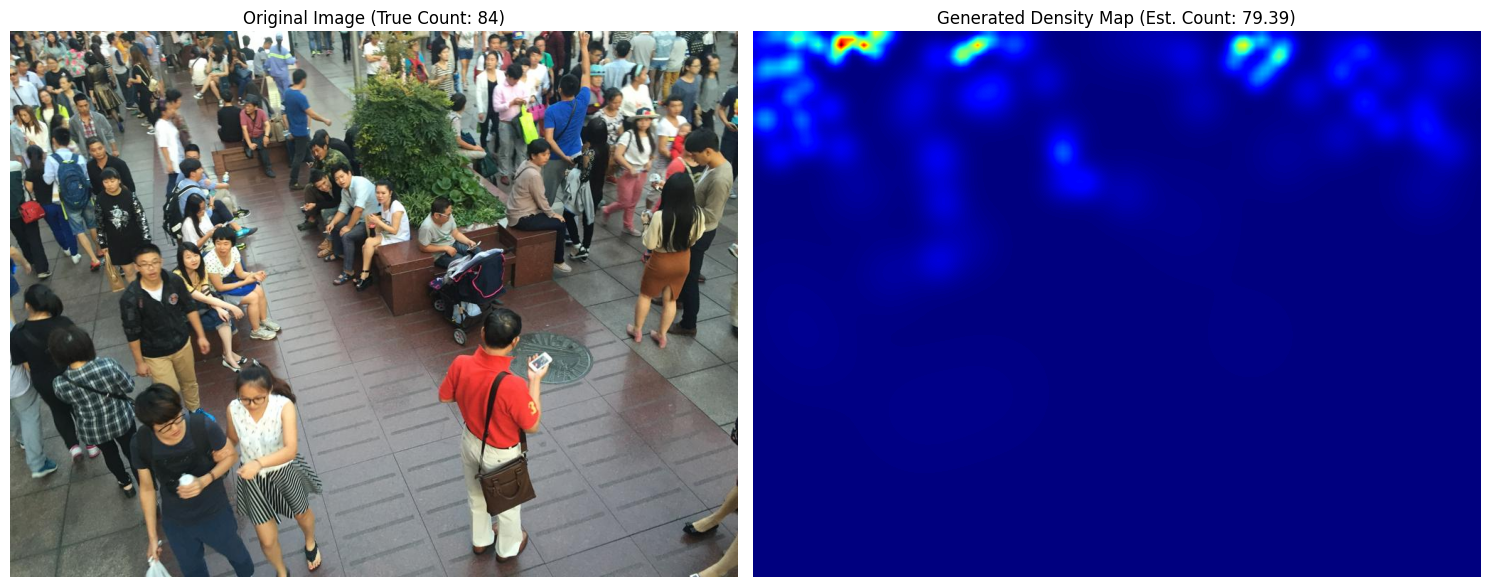

In [9]:
data = loadmat('/kaggle/input/crowd-dataset/crowd_wala_dataset/train_data/ground_truth/GT_IMG_40.mat')
point = data["image_info"][0][0][0][0][0]


img = Image.open("/kaggle/input/crowd-dataset/crowd_wala_dataset/train_data/images/IMG_40.jpg").convert("RGB")

density_map = generate_density_map(img, points=point.astype(int))
density_map_tensor = torch.from_numpy(density_map).float().unsqueeze(0).unsqueeze(0)

upsampled_density_map = torch.nn.functional.interpolate(
    density_map_tensor,
    size=(img.size[1], img.size[0]),
    mode='bilinear',
    align_corners=False).squeeze().cpu().numpy()


true_count = len(point)
estimated_count = np.sum(density_map)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title(f'Original Image (True Count: {true_count})')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(upsampled_density_map, cmap='jet')
plt.title(f'Generated Density Map (Est. Count: {estimated_count:.2f})')
plt.axis('off')

plt.tight_layout()
plt.show()

# Loss Fxn

In [18]:
learning_rate = 0.0001
epochs = 1

loss_fxn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop

In [ ]:
start = time.time()
losses = []


for i in range(epochs):

    total_epoch_loss = 0
    count = 0

    for batch_image, batch_density_map in train_loader:

        batch_image, batch_density_map = batch_image.to(device), batch_density_map.to(device)

        output = model(batch_image)

        loss = loss_fxn(output, batch_density_map)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1
        print(f"Batch No.: {count}, Time Elapsed: {(time.time() - start):.2f}")
    
        total_epoch_loss += loss.item()

    avg_epoch_loss = total_epoch_loss / len(train_loader)
    losses.append(avg_epoch_loss)
    print(f"Epoch: {i+1}, Loss: {avg_epoch_loss}")        

In [ ]:
plt.plot(range(1, 31), losses)
plt.show()

In [ ]:
torch.save(model.state_dict(), 'model_weights_CSRNetMAE19-epoch.pth')

In [17]:
model = CSRNet()
model = model.to(device)
model.load_state_dict(torch.load("/kaggle/input/csrnet19/pytorch/default/1/model_weights_CSRNetMAE19-epoch.pth"))

<All keys matched successfully>

# Evaluation

In [19]:
model.eval()

CSRNet(
  (frontend): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

In [20]:
total_loss = 0
total_mae = 0
total_mse = 0
count = 0

for batch_image, batch_density_map in test_loader:

    batch_image, batch_density_map = batch_image.to(device), batch_density_map.to(device)

    with torch.no_grad():
        output = model(batch_image)

    loss = loss_fxn(output, batch_density_map)

    predicted_counts = output.sum(dim=[1, 2, 3])
    true_counts = batch_density_map.sum(dim=[1, 2, 3])

    abs_diff = torch.abs(predicted_counts - true_counts)
    squared_diff = (predicted_counts - true_counts) ** 2
    
    total_mae += torch.sum(abs_diff).item()
    total_mse += torch.sum(squared_diff).item()

    count += 1
    print(f"Batch No.: {count}, Loss: {loss.item()}")

    total_loss += loss.item()

avg_loss = total_loss / (len(test_loader))
avg_mae = total_mae / (len(test_loader) * batch_size)
avg_mse = total_mse / (len(test_loader) * batch_size)

print(f"Avg Loss: {avg_loss}") 
print(f"Avg MAE: {avg_mae}")
print(f"Avg MSE: {avg_mse}")

Batch No.: 1, Loss: 0.0026827973779290915
Batch No.: 2, Loss: 0.0057873292826116085
Batch No.: 3, Loss: 0.008016720414161682
Batch No.: 4, Loss: 0.0045115752145648
Batch No.: 5, Loss: 0.006311330012977123
Batch No.: 6, Loss: 0.0028339638374745846
Batch No.: 7, Loss: 0.00457388861104846
Batch No.: 8, Loss: 0.004638254642486572
Batch No.: 9, Loss: 0.004960577003657818
Batch No.: 10, Loss: 0.012960227206349373
Batch No.: 11, Loss: 0.003329693339765072
Batch No.: 12, Loss: 0.004407051019370556
Batch No.: 13, Loss: 0.004210673738270998
Batch No.: 14, Loss: 0.00829135812819004
Batch No.: 15, Loss: 0.0048685744404792786
Batch No.: 16, Loss: 0.0036860848776996136
Batch No.: 17, Loss: 0.00423007644712925
Batch No.: 18, Loss: 0.004277101717889309
Batch No.: 19, Loss: 0.007393190637230873
Batch No.: 20, Loss: 0.007806131616234779
Batch No.: 21, Loss: 0.00377280218526721
Batch No.: 22, Loss: 0.004849793389439583
Batch No.: 23, Loss: 0.004594472702592611
Batch No.: 24, Loss: 0.005126575473695993
Ba

In [21]:
total_loss = 0
total_mae = 0
total_mse = 0
count = 0

for batch_image, batch_density_map in train_loader:

    batch_image, batch_density_map = batch_image.to(device), batch_density_map.to(device)

    with torch.no_grad():
        output = model(batch_image)

    loss = loss_fxn(output, batch_density_map)

    predicted_counts = output.sum(dim=[1, 2, 3])
    true_counts = batch_density_map.sum(dim=[1, 2, 3])

    abs_diff = torch.abs(predicted_counts - true_counts)
    squared_diff = (predicted_counts - true_counts) ** 2
    
    total_mae += torch.sum(abs_diff).item()
    total_mse += torch.sum(squared_diff).item()

    count += 1
    print(f"Batch No.: {count}, Loss: {loss.item()}")

    total_loss += loss.item()

avg_loss = total_loss / (len(train_loader))
avg_mae = total_mae / (len(train_loader) * batch_size)
avg_mse = total_mse / (len(train_loader) * batch_size)

print(f"Avg Loss: {avg_loss}")
print(f"Avg MAE: {avg_mae}")
print(f"Avg MSE: {avg_mse}")

Batch No.: 1, Loss: 0.0036066926550120115
Batch No.: 2, Loss: 0.006539264228194952
Batch No.: 3, Loss: 0.005219652783125639
Batch No.: 4, Loss: 0.00336376391351223
Batch No.: 5, Loss: 0.005437265150249004
Batch No.: 6, Loss: 0.004918571561574936
Batch No.: 7, Loss: 0.003419190179556608
Batch No.: 8, Loss: 0.0038007167167961597
Batch No.: 9, Loss: 0.003855885472148657
Batch No.: 10, Loss: 0.006243412382900715
Batch No.: 11, Loss: 0.007043325807899237
Batch No.: 12, Loss: 0.008161092177033424
Batch No.: 13, Loss: 0.0046639954671263695
Batch No.: 14, Loss: 0.006537977606058121
Batch No.: 15, Loss: 0.003595478367060423
Batch No.: 16, Loss: 0.004290438257157803
Batch No.: 17, Loss: 0.0061611514538526535
Batch No.: 18, Loss: 0.004973188042640686
Batch No.: 19, Loss: 0.0040398528799414635
Batch No.: 20, Loss: 0.004662138409912586
Batch No.: 21, Loss: 0.006916073616594076
Batch No.: 22, Loss: 0.004581866320222616
Batch No.: 23, Loss: 0.005450408905744553
Batch No.: 24, Loss: 0.0071440911851823

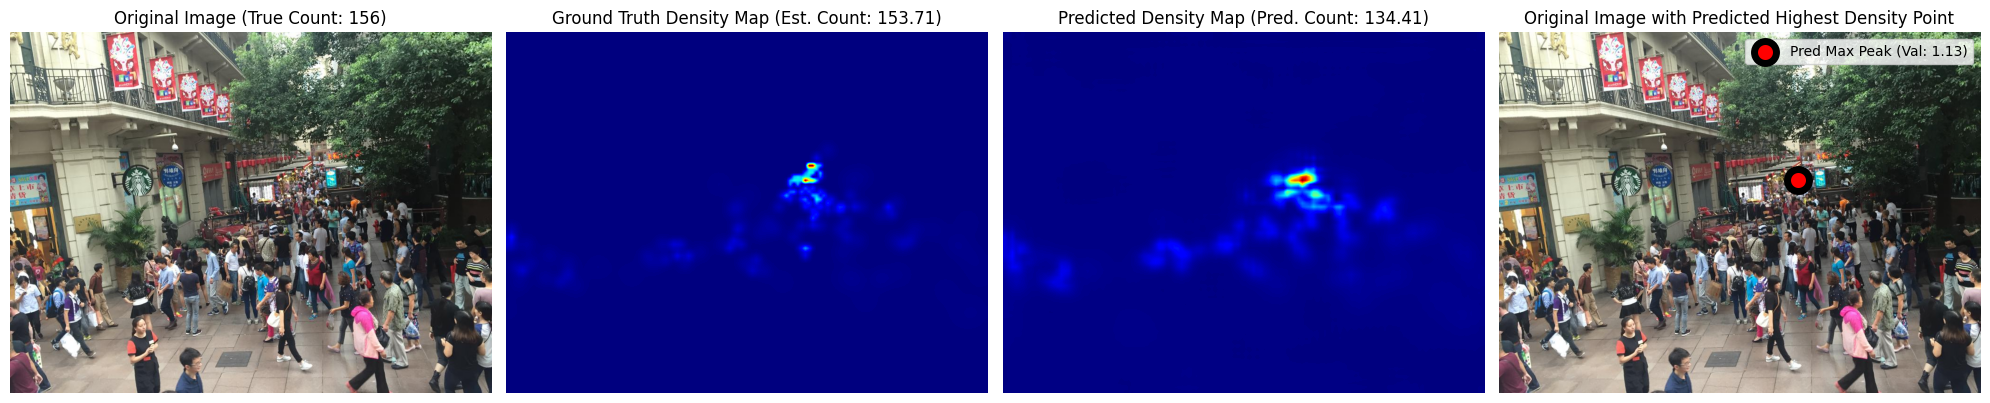

In [32]:
from scipy.ndimage import maximum_filter


data = loadmat('/kaggle/input/crowd-dataset/crowd_wala_dataset/test_data/ground_truth/GT_IMG_36.mat')
point = data["image_info"][0][0][0][0][0]


img = Image.open("/kaggle/input/crowd-dataset/crowd_wala_dataset/test_data/images/IMG_36.jpg").convert("RGB")
width, height = img.size

density_map = generate_density_map(img, points=point.astype(int))
density_map_tensor = torch.from_numpy(density_map).float().unsqueeze(0).unsqueeze(0)
upsampled_density_map = torch.nn.functional.interpolate(
    density_map_tensor,
    size=(img.size[1], img.size[0]),
    mode='bilinear',
    align_corners=False).squeeze().cpu().numpy()


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
with torch.no_grad():
    img_ = transform(img)
    img_ = img_.to(device)
    predicted_density_map = model(img_.unsqueeze(0))
    upsampled_predicted_density_map = torch.nn.functional.interpolate(
        predicted_density_map,
        size=(height, width),
        mode='bilinear',
        align_corners=False).squeeze().cpu().numpy()


true_count = len(point)
estimated_count = np.sum(density_map)
predicted_count = predicted_density_map.sum().item()


max_pred_density_value = np.max(upsampled_predicted_density_map)
max_pred_density_coords_flat = np.argmax(upsampled_predicted_density_map)
max_pred_density_peak_row, max_pred_density_peak_col = np.unravel_index(
    max_pred_density_coords_flat, upsampled_predicted_density_map.shape
)


plt.figure(figsize=(20, 6))

plt.subplot(1, 4, 1)
plt.imshow(img)
plt.title(f'Original Image (True Count: {true_count})')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(upsampled_density_map, cmap='jet')
plt.title(f'Ground Truth Density Map (Est. Count: {estimated_count:.2f})')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(upsampled_predicted_density_map, cmap='jet')
plt.title(f'Predicted Density Map (Pred. Count: {predicted_count:.2f})')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(img)
plt.scatter(max_pred_density_peak_col, max_pred_density_peak_row, 
            color='red', s=1000, marker='.', edgecolors='black', linewidth=5, 
            label=f'Pred Max Peak (Val: {max_pred_density_value:.2f})')
plt.title(f'Original Image with Predicted Highest Density Point')
plt.axis('off')
plt.legend()

plt.tight_layout()
plt.show()